# Bray–Curtis dissimilarity between regions defined by important historical boundaries

Compare historical regions in terms of their building composition using Bray–Curtis dissimilarity statistic.

In [1]:
import geopandas as gpd
import pandas as pd
import scipy.stats as stats
import shapely
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from libpysal import graph
from scipy.spatial import distance
import os

import preprocess_data

Retrieve building dataset and levels of clusters

In [2]:
buildings, levels = preprocess_data.get_buildings("/data/uscuni-ulce/boundaries_of_change/classification/")

List layers of influential boundaries across Central European history

In [3]:
gpd.list_layers("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg")

,name,geometry_type
0,1050_political,MultiPolygon
1,1250_political,MultiPolygon
2,1480_political,MultiPolygon
3,1550_religion,MultiPolygon
4,1570_political,MultiPolygon
5,1648_political,MultiPolygon
6,1721_political,MultiPolygon
7,1815_political,MultiPolygon
8,1871_political,Polygon
9,1900_languages,MultiPolygon


In [4]:
boundary_list = list(gpd.list_layers("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg").name)

Define area of interest

<Axes: >

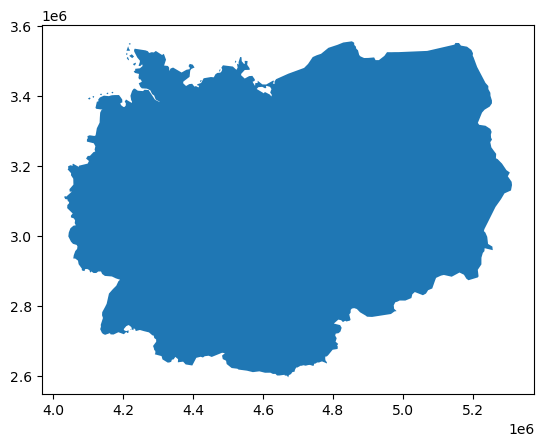

In [5]:
aoi = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer="1994_political")
aoi = aoi.dissolve()
aoi.plot()

**Example**: Consider `1994_political` map

In [6]:
layer_of_interest = boundary_list[-1]

Retrieve building counts per region and normalize

In [7]:
building_counts = preprocess_data.get_building_counts_per_region(buildings, gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer=layer_of_interest))

In [8]:
normalized_building_counts = preprocess_data.normalize_building_counts(building_counts)

In [9]:
normalized_building_counts

level_4,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
NAME,,,,,,,,,,,,,,,,,
Austria,0.067609,0.022257,0.000000,0.126930,0.006812,0.125637,0.066816,0.060131,0.000000,0.000000,0.000502,0.124718,0.346883,0.001677,0.044346,0.000000,0.005681
Czechia,0.161139,0.012590,0.000000,0.113605,0.003269,0.077983,0.043114,0.040236,0.000000,0.000000,0.002151,0.181660,0.295881,0.001827,0.044555,0.000000,0.021989
Germany,0.188684,0.019957,0.000026,0.178295,0.089609,0.148829,0.026715,0.169675,0.000031,0.000435,0.002384,0.018317,0.093611,0.013993,0.044538,0.000004,0.004900
Poland,0.039166,0.002699,0.000000,0.100664,0.002002,0.038007,0.009198,0.200354,0.000000,0.011277,0.079658,0.189038,0.183274,0.081794,0.035788,0.000000,0.027080
Slovakia,0.057435,0.005524,0.000000,0.192803,0.007877,0.181338,0.011169,0.220844,0.000000,0.001869,0.016090,0.075426,0.044476,0.079736,0.090591,0.000000,0.014820


Compute pairwise Bray–Curtis dissimilarity matrix

In [10]:
bray_curtis_matrix = preprocess_data.compute_bc_matrix(normalized_building_counts)
bray_curtis_matrix

NAME,Austria,Czechia,Germany,Poland,Slovakia
NAME,,,,,
Austria,0.000000,0.168788,0.402857,0.396492,0.434253
Czechia,0.168788,0.000000,0.399120,0.341339,0.507523
Germany,0.402857,0.399120,0.000000,0.469162,0.292153
Poland,0.396492,0.341339,0.469162,0.000000,0.339705
Slovakia,0.434253,0.507523,0.292153,0.339705,0.000000


Plot as a heatmap

<Axes: xlabel='NAME', ylabel='NAME'>

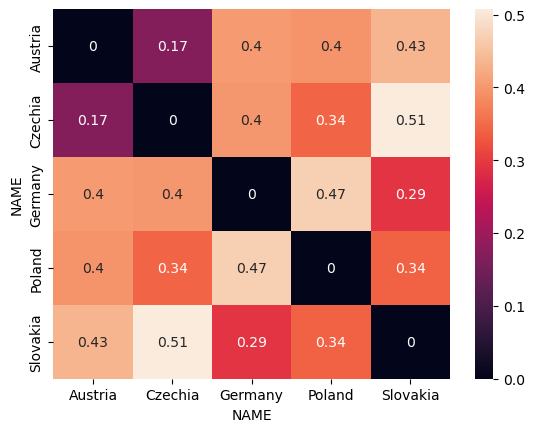

In [11]:
sns.heatmap(bray_curtis_matrix, annot=True)

Compute Bray–Curtis matrix for each cluster level

In [12]:
def generate_bc_heatmaps_for_boundary(level_list, boundary_name):

    fig, axs = plt.subplots(7, 1, figsize=(30, 30))
    axs = axs.flatten()
    
    for level, ax in zip(level_list, axs):
        bc = pd.read_parquet(f'/data/uscuni-ulce/boundaries_of_change/bc_matrices/bc_{boundary_name}_{level}.pq')
        sns.heatmap(bc, annot=True, ax=ax, square=True)
        ax.set_title(level)

    fig.suptitle(boundary_name)
    fig.tight_layout()

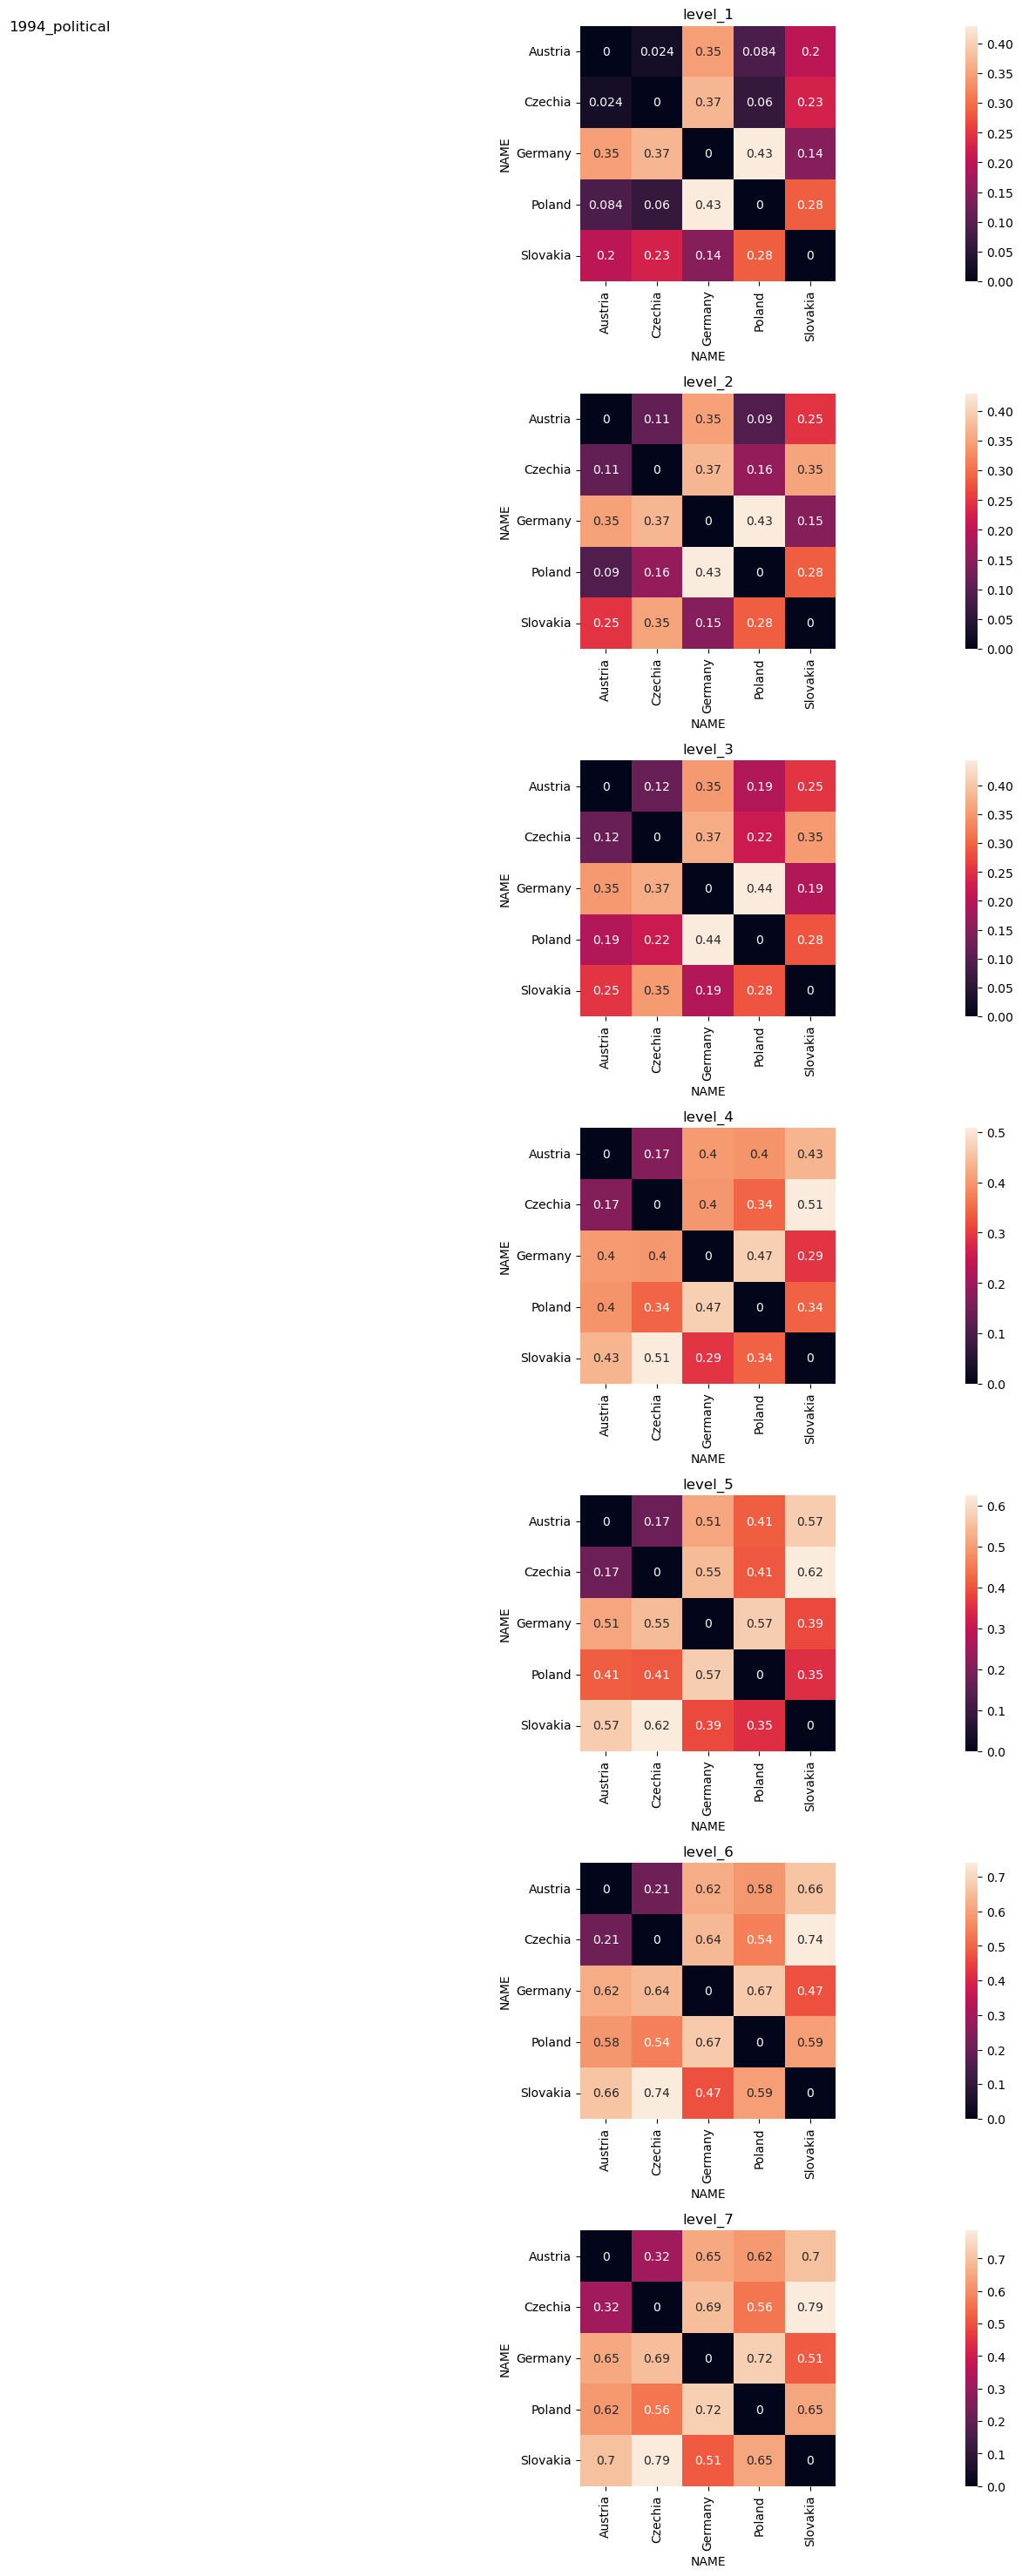

In [13]:
generate_bc_heatmaps_for_boundary(levels, layer_of_interest)

## Run to generate Bray–Curtis matrices for each level and historical layer, save to parquet

In [15]:
from tqdm.auto import tqdm

def generate_bc_matrices(list_of_boundaries, level_list):
    bc_matrices_path = "/data/uscuni-ulce/boundaries_of_change/bc_matrices/"
    if not os.path.exists(bc_matrices_path):
        os.mkdir(bc_matrices_path)
    for bnd in tqdm(list_of_boundaries, desc=f"Processing boundaries..."):
        boundary = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer=bnd)
        
        for level in tqdm(level_list, desc=f"Generating matrices for {bnd}"):
            building_counts = preprocess_data.get_building_counts_per_region(buildings, boundary, level)
            building_counts_norm = preprocess_data.normalize_building_counts(building_counts)
            
            bray_curtis_matrix = compute_bc_matrix(building_counts_norm)
            output_path = os.path.join(bc_matrices_path, f'bc_{bnd}_{level}.pq')
            bray_curtis_matrix.to_parquet(output_path)

In [15]:
generate_bc_matrices(boundary_list, levels)

Processing boundaries...:   0%|          | 0/14 [00:00<?, ?it/s]

Generating matrices for 1871_political:   0%|          | 0/7 [00:00<?, ?it/s]

Generating matrices for 1960_political:   0%|          | 0/7 [00:00<?, ?it/s]

Generating matrices for 1994_political:   0%|          | 0/7 [00:00<?, ?it/s]

Generating matrices for 1050_political:   0%|          | 0/7 [00:00<?, ?it/s]

Generating matrices for 1250_political:   0%|          | 0/7 [00:00<?, ?it/s]

Generating matrices for 1480_political:   0%|          | 0/7 [00:00<?, ?it/s]

Generating matrices for 1570_political:   0%|          | 0/7 [00:00<?, ?it/s]

Generating matrices for 1550_religion:   0%|          | 0/7 [00:00<?, ?it/s]

Generating matrices for 1648_political:   0%|          | 0/7 [00:00<?, ?it/s]

Generating matrices for 1721_political:   0%|          | 0/7 [00:00<?, ?it/s]

Generating matrices for 1815_political:   0%|          | 0/7 [00:00<?, ?it/s]

Generating matrices for 1900_languages:   0%|          | 0/7 [00:00<?, ?it/s]

Generating matrices for 1910_political:   0%|          | 0/7 [00:00<?, ?it/s]

Generating matrices for 1930_political:   0%|          | 0/7 [00:00<?, ?it/s]